In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pickle, pprint
import csv

from scipy.stats import pearsonr
from scipy.spatial import distance
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import quantile_transform

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
X_base=np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
y_base=np.array([[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [3]:
def gen_corr():
    """Generar 
    Preguntas y respuestas correctas
    """
    pregs=np.random.randint(0,15,3)
    x_compuesta=X_base[pregs[0]]+X_base[pregs[1]]+X_base[pregs[2]]
    y_compuesta=y_base[pregs[0]]+y_base[pregs[1]]+y_base[pregs[2]]+y_base[np.random.randint(0,15)]
    return 1,x_compuesta,y_compuesta

def gen_err():
    """Generar 
    Preguntas y respuestas equivocadas
    """
    pregs=np.random.randint(0,15,3)
    resps=np.random.randint(0,15,4)
    for i_n,rp in enumerate(resps):
        if((rp==pregs[0])|(rp==pregs[1])|(rp==pregs[2])):
            resps[i_n]=np.random.randint(0,15)
            for i_n,rp in enumerate(resps):
                if((rp==pregs[0])|(rp==pregs[1])|(rp==pregs[2])):
                    resps[i_n]=np.random.randint(0,15)
    x_compuesta=X_base[pregs[0]]+X_base[pregs[1]]+X_base[pregs[2]]
    y_compuesta=y_base[resps[0]]+y_base[resps[1]]+y_base[resps[2]]+y_base[resps[3]]
    return 0,x_compuesta,y_compuesta

In [46]:
def mat_ocurr(X_corrs, y_corrs):
    """Generar np.array de ocurrencias
    Toma cada palabra de la matriz de ocurrencias en la pregunta y devuelve la suma de las ocurrencias de las palabras en las respuestas correctas.
    Esto da un conteo de la palabra de la pregunta y sus palabras co-ocurrentes en las respuestas.
    X_corrs=ocurrencias de las palabras en las preguntas
    y_corrs=ocurrencias de las palabras en las respuestas
    """
    y_emb_2=[]
    for quest in range(X_corrs.shape[1]):
        y_pfil=y_corrs[X_corrs[:,quest]==1].sum(axis=0)
        y_emb_2.append(y_pfil)
    y_emb_2=np.array(y_emb_2)
    return y_emb_2

def preg_expect(preg,y_emb_2):
    """Generar np.array de probabilidades de expectativas
    Toma para cada palabra ocurrente en la pregunta y busca sus palabras co-ocurrentes, se toman las palabras ocurrentes en la pregunta y se obtienen todas las sumas de las palabras esperadas en las respuestas. Esta suma se normaliza al minimax para tener una propbabilidad de ocurrencia de palabras en la respuesta para esa combinación de palabras en la pregunta, lo cual da la expectativa (probabilidad) de las palabras en la respuesta.
    preg=embedding de ocurrencias de las palabras en la pregunta
    y_emb_2=ocurrencias de las palabras en la respuesta por cada palabra en la pregunta (salida de mat_ocurr)
    """
    y_embd_3=[]
    for ith,word in enumerate(preg):#X_dat_corr[sample]):
        if word>0:
            y_embd_3.append(y_emb_2[ith])# OJO Embedding de frecuencias PREVIAMENTE DECLARADO
    y_embd_3=np.array(y_embd_3)
    y_embd_3=y_embd_3.sum(axis=0)
    y_embd_3=(y_embd_3-min(y_embd_3))/(max(y_embd_3)-min(y_embd_3))#y_embd_3/max(y_embd_3)#cuando min=0 solo se divide sobre max() 
    return y_embd_3

def dists_resp(preg_emb, resp_emb, expect_emb):
    """Generar distancias entre la expectativa y la respuesta
    Toma para cada palabra ocurrente en la pregunta y busca sus palabras co-ocurrentes, se toman las palabras ocurrentes en la pregunta y se obtienen todas las sumas de las palabras esperadas en las respuestas. Esta suma se normaliza al minimax para tener una propbabilidad de ocurrencia de palabras en la respuesta para esa combinación de palabras en la pregunta, lo cual da la expectativa (probabilidad) de las palabras en la respuesta.
    preg_emb=embedding de ocurrencias de las palabras en la pregunta
    resp_emb=embedding de ocurrencias de las palabras en la respuesta
    expect_emb=np.array de las expectativas de las palabras en la respuesta
    
    returns distancia coseno , distancia euclideana
    """
    x_in=(preg_emb>0)*1# validar que son ocurrencias
    real=(resp_emb>0)*1# validar que son ocurrencias
    pred=expect_emb
    
    real_w=real[real>0]
    pred_w=pred[real>0]
    cosine=distance.cosine(real_w,pred_w)
    euclidean=distance.euclidean(real_w,pred_w)
#     pearson=distance.correlation(real_w,pred_w)#pearsonr(real_w,pred_w)
    return cosine,euclidean#,pearson

In [35]:
calif=[]
X_dat=[]
y_dat=[]
for i in range(10000):
    cal1,x_d1,y_d1 = gen_corr()
    calif.append(cal1)
    X_dat.append(x_d1)
    y_dat.append(y_d1)
    cal0,x_d0,y_d0 = gen_err()
    calif.append(cal0)
    X_dat.append(x_d0)
    y_dat.append(y_d0)

calif=np.array(calif)
X_dat=np.array(X_dat)
y_dat=np.array(y_dat)

# Paso 1
Tomar las respuestas correctas

In [36]:
X_dat_corr=X_dat[calif==1,:]
y_dat_corr=y_dat[calif==1,:]

In [37]:
X_dat[calif==1,:].shape

(10000, 20)

# Paso 2
crear una matriz de embeddings donde se suman las palabras co-ocurrentes en la respuestas correctas para cada una de las palabras de las preguntas

In [38]:
# ##########Declarar la función
# def mat_ocurr(X_corrs, y_corrs):
#     y_emb_2=[]
#     for quest in range(X_corrs.shape[1]):
# #         X_filt=X_corrs[X_corrs[:,quest]==1]
# #         y_filt=y_corrs[X_corrs[:,quest]==1]
#         y_pfil=y_corrs[X_corrs[:,quest]==1].sum(axis=0)
#     #     y_pfil=y_pfil/max(y_pfil)
#         y_emb_2.append(y_pfil)
#     y_emb_2=np.array(y_emb_2)
#     return y_emb_2

In [65]:
y_emb_2=[]
for quest in range(X_dat_corr.shape[1]):
    y_pfil=y_dat_corr[X_dat_corr[:,quest]==1].sum(axis=0)
    y_emb_2.append(y_pfil)
y_emb_2=np.array(y_emb_2)
y_emb_2

array([[   0,    0,    0,    0,    0, 1538,  878,  912,  879,  860, 1574,
         925,  867,  896,  889, 1529,  900,  867,  933,  917],
       [   0,    0,    0,    0,    0,  912, 1515,  919,  919,  891,  913,
        1597,  925,  861,  904,  870, 1522,  860,  883,  893],
       [   0,    0,    0,    0,    0,  912,  847, 1562,  855,  888,  905,
         898, 1495,  892,  900,  849,  855, 1509,  869,  916],
       [   0,    0,    0,    0,    0,  930,  864,  935, 1494,  864,  879,
         924,  874, 1514,  907,  919,  840,  887, 1580,  889],
       [   0,    0,    0,    0,    0,  866,  921,  919,  852, 1492,  922,
         892,  910,  887, 1589,  913,  887,  868,  878, 1548],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    

In [73]:
quest=0
y_dat_corr[X_dat_corr[:,quest]==1]#.shape#.sum(axis=0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
y_emb_ocurrs=mat_ocurr(X_dat_corr, y_dat_corr)
print(y_emb_ocurrs[:5])

[[   0    0    0    0    0 1538  878  912  879  860 1574  925  867  896
   889 1529  900  867  933  917]
 [   0    0    0    0    0  912 1515  919  919  891  913 1597  925  861
   904  870 1522  860  883  893]
 [   0    0    0    0    0  912  847 1562  855  888  905  898 1495  892
   900  849  855 1509  869  916]
 [   0    0    0    0    0  930  864  935 1494  864  879  924  874 1514
   907  919  840  887 1580  889]
 [   0    0    0    0    0  866  921  919  852 1492  922  892  910  887
  1589  913  887  868  878 1548]]


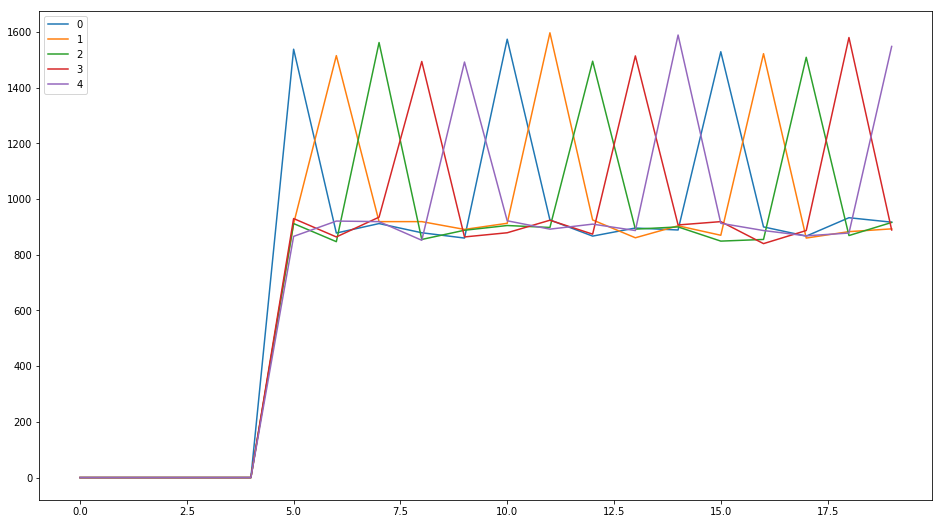

In [40]:
colormap = cm.Set1.colors

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)
for ith,ans_emb in enumerate(y_emb_ocurrs[:5]):
    ax.plot(ans_emb,label=ith)#x=range(len(ans_emb)),
#                 y=ans_emb) #Pregunta
plt.legend()
plt.show()

# Paso 3
Tomar cada palabra de la pregunta y sumar las frecuencias de las palabras esperadas en las respuestas de la matriz de embeddings. Así se obtienen las palabras esperadas para esa pregunta. NORMALIZACIÓN MINIMAX

In [41]:
# def preg_expect(preg,y_emb_2):
#     y_embd_3=[]
#     for ith,word in enumerate(preg):#X_dat_corr[sample]):
#         if word>0:
#             y_embd_3.append(y_emb_2[ith])# OJO Embedding de frecuencias PREVIAMENTE DECLARADO
#     y_embd_3=np.array(y_embd_3)
#     y_embd_3=y_embd_3.sum(axis=0)
#     y_embd_3=(y_embd_3-min(y_embd_3))/(max(y_embd_3)-min(y_embd_3))#y_embd_3/max(y_embd_3)#cuando min=0 solo se divide sobre max() 
#     return y_embd_3

In [50]:
sample=np.random.randint(X_dat.shape[0])#X_dat_corr.shape[0])
y_embd_3=preg_expect(X_dat[sample],y_emb_ocurrs)

print(sample,calif[sample])

19530 1


# Paso 4
Calcular la distancia desde la expectativa a la respuesta
* Se toma la OCURRENCIA de la palabra, no la frecuencia 
* Solamente para las palabras en la respuesta

In [51]:
# def dists_resp(preg_emb, resp_emb, expect_emb):
#     x_in=(preg_emb>0)*1
#     real=(resp_emb>0)*1
#     pred=expect_emb
    
#     real_w=real[real>0]
#     pred_w=pred[real>0]
#     cosine=distance.cosine(real_w,pred_w)
#     euclidean=distance.euclidean(real_w,pred_w)
#     return cosine,euclidean

In [52]:
cos_dist,euclid_dist=dists_resp(X_dat[sample],y_dat[sample],y_embd_3)

In [53]:
print(cos_dist)
print(euclid_dist)


0.003748511771881291
0.21827302321968833


19530 1


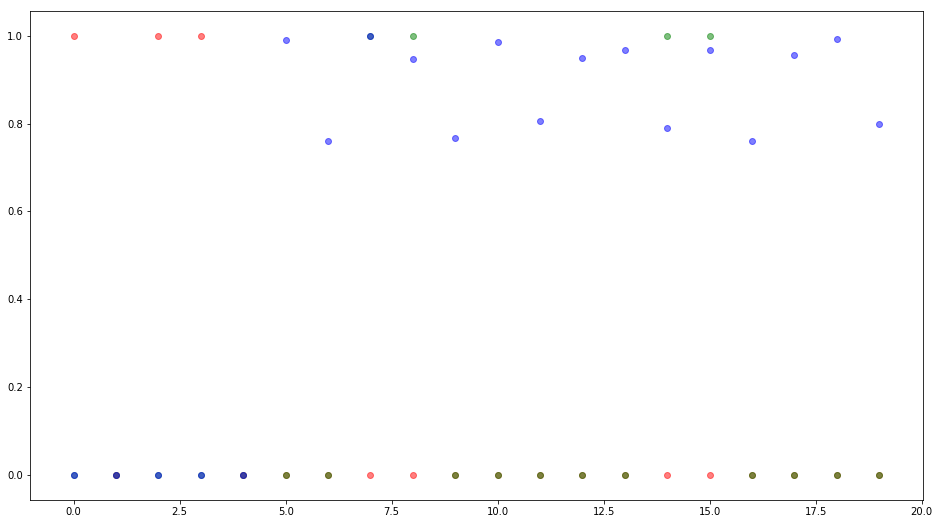

In [54]:
print(sample, calif[sample] )

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)


ax.scatter(x=range(len(X_dat[sample])),
            y=(X_dat[sample]>0)*1, c="r", alpha=.5) #Pregunta
ax.scatter(x=range(len(X_dat[sample])),
            y=(y_dat[sample]>0)*1, c="g", alpha=.5) #respuesta
ax.scatter(x=range(len(X_dat[sample])),
            y=y_embd_3, c="b", alpha=.5) #Predicción

plt.show()

In [56]:
coss=[]
eucl=[]
pear=[]
for sample in range(X_dat.shape[0]):
    y_embd_3=preg_expect(X_dat[sample],y_emb_ocurrs)
    cos_dist,euclid_dist=dists_resp(X_dat[sample],y_dat[sample],y_embd_3)
    coss.append(cos_dist)
    eucl.append(euclid_dist)
    pear.append(pearson_dist)
coss=np.array(coss)
eucl=np.array(eucl)

Text(0.5, 1.0, 'Distancia coseno')

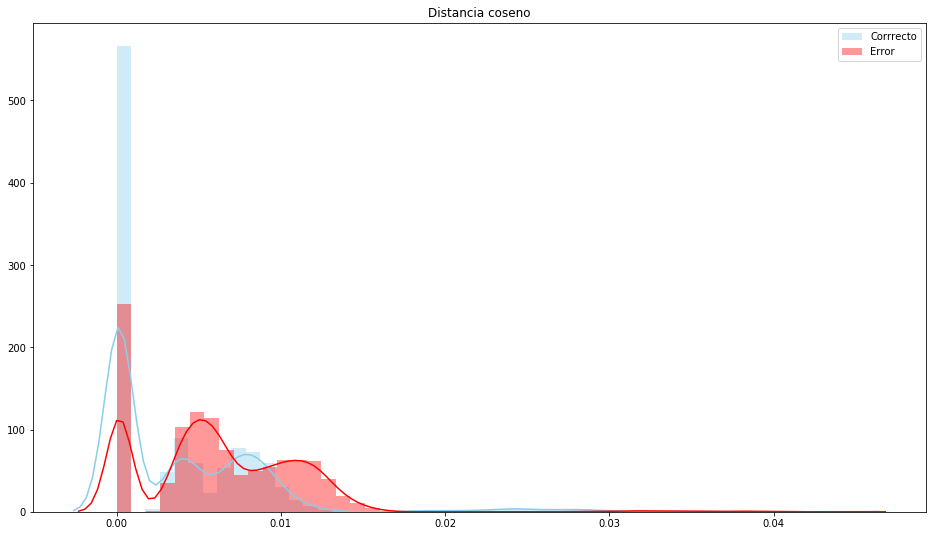

In [61]:
plt.figure(figsize=(16,9))
sns.distplot( coss[calif==1] , color="skyblue", label="Corrrecto")
sns.distplot( coss[calif==0] , color="red", label="Error")
plt.legend()
plt.title("Distancia coseno")

Text(0.5, 1.0, 'Distancia Euclideana')

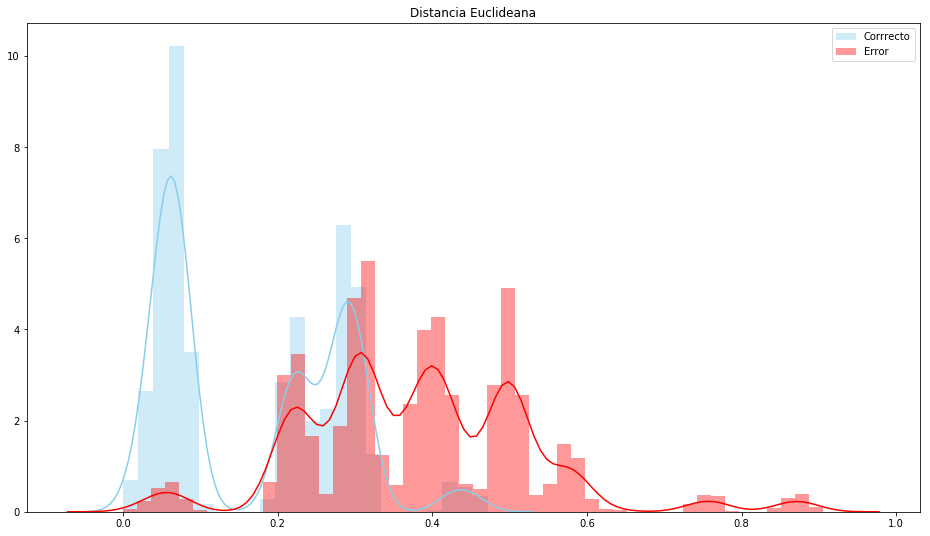

In [62]:
plt.figure(figsize=(16,9))
sns.distplot( eucl[calif==1] , color="skyblue", label="Corrrecto")
sns.distplot( eucl[calif==0] , color="red", label="Error")
plt.legend()
plt.title("Distancia Euclideana")

In [60]:
coss
eucl
calif

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
# ANN_info= MLPClassifier(solver='adam', 
ANN_info= MLPRegressor(solver='adam', 
                       alpha=1e-10, 
                       hidden_layer_sizes=(int(X_dat.shape[1]*2),
                                           int(X_dat.shape[1]*2),
                                         ),
                       verbose=True,
                       max_iter=2500,
                       tol=1e-10,
                       activation="identity",# : {‘identity’, ‘logistic’, ‘tanh’, ‘relu’},
                       n_iter_no_change=500)
predictor_ANN_info= ANN_info.fit(X_dat,y_dat)
y_pred= predictor_ANN_info.predict(y_dat)


In [ ]:
for quest in range(5):
    X_filt=X_dat[X_dat[:,quest]==1]
    y_filt=y_dat[X_dat[:,quest]==1]
    y_pfil=y_pred[X_dat[:,quest]==1]

    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(1, 1, 1)
    for sample_index in range (len(X_filt)):
        x_in=X_filt[sample_index,:]
        real=y_filt[sample_index,:]
        pred=y_pfil[sample_index,:]

        ax.scatter(x=range(len(real)),
                    y=x_in, c="r") #Pregunta
        ax.scatter(x=range(len(real)),
                    y=real, c="g") #respuesta
        ax.scatter(x=range(len(real)),
                    y=pred, c="b", alpha=.005) #Predicción

    plt.show()

In [ ]:
pred_info = RandomForestRegressor(n_estimators=20,
                                 max_depth=20,
                                 verbose=1,
                                 n_jobs=-1)

# pred_info =  OneVsRestClassifier(SVC(kernel='linear'))

predictor_info=pred_info.fit(X_dat,y_dat)
y_pred= predictor_info.predict(y_dat)



In [ ]:
for quest in range(5):
    X_filt=X_dat[X_dat[:,quest]==1]
    y_filt=y_dat[X_dat[:,quest]==1]
    y_pfil=y_pred[X_dat[:,quest]==1]

    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(1, 1, 1)
    for sample_index in range (len(X_filt)):
        x_in=X_filt[sample_index,:]
        real=y_filt[sample_index,:]
        pred=y_pfil[sample_index,:]

        ax.scatter(x=range(len(real)),
                    y=x_in, c="r") #Pregunta
        ax.scatter(x=range(len(real)),
                    y=real, c="g") #respuesta
        ax.scatter(x=range(len(real)),
                    y=pred, c="b", alpha=.005) #Predicción

    plt.show()